In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym[classic_control]
!pip install keras-rl2

from pyvirtualdisplay import Display
Display().start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libpython2-stdlib python-opengl python2 python2-minimal
0 upgraded, 5 newly installed, 0 to remove and 23 not upgraded.
Need to get 621 kB of archives.
After this operation, 6,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-stdlib amd64 2.7.17-2ubuntu4 [7,072 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2 amd64 2.7.17-2ubuntu4 [26.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu f

In [2]:
import numpy as np
import random
import gym
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
%matplotlib inline

In [3]:
env_name = 'Acrobot-v1'
env = gym.make(env_name)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


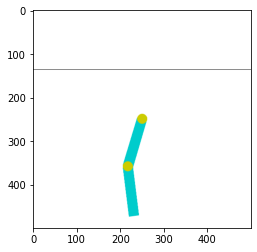

In [4]:
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(50):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)
  # if done:
  #   env.reset()
env.close()

In [5]:
nb_actions = env.action_space.n
nb_actions

3

In [6]:
nb_obs = env.observation_space.shape
nb_obs

(6,)

In [7]:
model = Sequential()

model.add(Flatten(input_shape=(1,)+nb_obs))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))

# Neurons == action_space
model.add(Dense(nb_actions))
model.add(Activation('linear'))

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 activation_2 (Activation)   (None, 64)                0

In [9]:
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [10]:
memory = SequentialMemory(limit=50000,window_length=1)

In [11]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
              value_max=1.0,
              value_min=0.1, 
              value_test=0.05,
              nb_steps=150000
              )

In [13]:
dqn = DQNAgent(model=model,nb_actions=nb_actions,
               memory=memory,nb_steps_warmup=1000,
                batch_size=32,gamma=0.99,
               target_model_update=1000,policy=policy)

In [14]:
dqn.compile(Adam(learning_rate=1e-3),metrics=['mae'])

In [15]:
dqn.fit(env,nb_steps=150000,visualize=False,verbose=2)

Training for 150000 steps ...


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    500/150000: episode: 1, duration: 0.602s, episode steps: 500, steps per second: 831, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.036 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1000/150000: episode: 2, duration: 0.499s, episode steps: 500, steps per second: 1001, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.936 [0.000, 2.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   1500/150000: episode: 3, duration: 4.150s, episode steps: 500, steps per second: 120, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.996 [0.000, 2.000],  loss: 0.010887, mae: 0.482301, mean_q: -0.639197, mean_eps: 0.992500
   2000/150000: episode: 4, duration: 3.558s, episode steps: 500, steps per second: 141, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.048 [0.000, 2.000],  loss: 0.000462, mae: 0.473981, mean_q: -0.659870, mean_eps: 0.989503
   2500/150000: episode: 5, duration: 3.936s, episode steps: 500, steps per second: 127, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.022 [0.000, 2.000],  loss: 0.006998, mae: 1.212251, mean_q: -1.754884, mean_eps: 0.986503
   3000/150000: episode: 6, duration: 6.320s, episode steps: 500, steps per second:  79, episode reward: -500.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.022 [0.000, 2.000],  loss: 0.001146, mae: 1.201721, mean_q

In [ ]:
dqn.save_weights(f"my_weights_cartpole.h5f",overwrite=True)

In [ ]:
# dqn.load_weights(f"my_weights_cartpole.h5f",overwrite=True)

In [ ]:
dqn.test(env,nb_episodes=5,visualize=True)
env.close()